<a href="https://colab.research.google.com/github/rzunick/MNA-Proyecto-Integrador-Equipo-43/blob/main/Avance_4_Equipo_43.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Portada
Instituto Tecnológico de Estudios Superiores de Monterrey

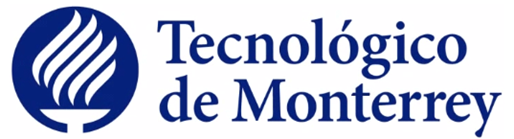

Maestría en Inteligencia Artificial Aplicada (MNA)
Curso: TC5035 Proyecto Integrador

Profesores: Dra. Grettel Barceló Alonso y Dr. Luis Eduardo Falcón

Proyecto: Reconocimiento y Clasificación de Objetos basado en Colores para Detección en Vivo en Cámaras de Seguridad
##Avance 4. Modelos Alternativos

Equipo 43
* Ronald David Zuniga Sanchez - A01686240

#1 - Introducción

En el presente avance del Proyecto Integrador **Reconocimiento y Clasificación de Objetos basado en Colores para Detección en Vivo en Cámaras de Seguridad**, se desarrolla el análisis iterativo de modelos alternativos en busca del mejor rendimiento considerando diferentes configuraciones de hiperparámetros y arquitecturas.

Estableciendo medidas de calidad del modelo de aprendizaje automático y proporcionando un marco de referencia para evaluar y mejorar modelos más avanzados.

#2 - Importando el Dataset

Cargar Dataset en archivo .zip a entorno de Colab Manualmente a carpeta de Content.

Enlace: https://github.com/rzunick/MNA-Proyecto-Integrador-Equipo-43/blob/main/cifar_10_color.zip


In [1]:
import requests
from zipfile import ZipFile
import os
import shutil

# URL of the .zip file in the GitHub repository
github_zip_url = "https://github.com/rzunick/MNA-Proyecto-Integrador-Equipo-43/raw/main/cifar_10_color.zip?download="

# Path to save the downloaded .zip file
zip_file_path = '/content/cifar_10_color.zip'

# Download the .zip file from GitHub
response = requests.get(github_zip_url)
with open(zip_file_path, 'wb') as f:
    f.write(response.content)

# Verify the download
if response.status_code == 200:
    print("File downloaded successfully")
else:
    print("Failed to download file")

File downloaded successfully


In [2]:
#Specify zip file path
zip_file_path = '/content/cifar_10_color.zip'

In [3]:
# Confirmar tipo de archivo es tipo .zip
!file /content/cifar_10_color.zip

/content/cifar_10_color.zip: Zip archive data, at least v2.0 to extract, compression method=store


In [4]:
from zipfile import ZipFile

# Specify the directory where you want to extract the files
extract_to_directory = '/content'

# Create a ZipFile object
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extract_to_directory)

In [5]:
# Dataset Path
path = '/content/cifar_10_color'

#3 - Creación del Modelo Base


In [6]:
!pip install ray[tune]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.9 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

import os
import  numpy as np
import pandas as pd

from torch.utils.data import  Dataset, DataLoader
from  PIL import  Image
from  torchvision.transforms import  ToTensor, Compose, Resize, CenterCrop
import  glob

from ray import tune
#from ray.tune import Trainable
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import DataLoader
import logging

Se determinan las clases de colores a clasificar de acuerdo a lo definido en la creación de características en para el dataset de CIFAR-10 considerando lo siguiente:

1. Colores primarios de escala RYB.
2. Colores secundarios de escala RYB.
3. Colores adicionales de acuerdo a casos de uso y balance de clases: gris y rosado.

In [8]:
# Configuration 2: 10 labels
labels = ["Red","Yellow","Blue","Orange","Green","Purple","Black","White","Gray","Pink"]

def decode_label(index):
    return  labels[index]

def encode_label_from_path(path):
    for index,value in enumerate(labels):
        if value in path:
            return  index

Se genera carga de dataset de acuerdo a direccionamiento en repositorio y se visualiza distribución de etiquetas.

In [9]:
# Get image list
image_list = glob.glob(os.path.join(path, '**', '*.*'), recursive=True)
class_list = [encode_label_from_path(item) for item in image_list]

In [10]:
# Count the number of images per class
from collections import Counter
label_counts = Counter(class_list)
print("Label counts:", label_counts)

Label counts: Counter({8: 5925, 6: 5799, 7: 4838, 0: 4764, 4: 3794, 1: 2946, 3: 2685, 2: 2541, 9: 2007, 5: 682})


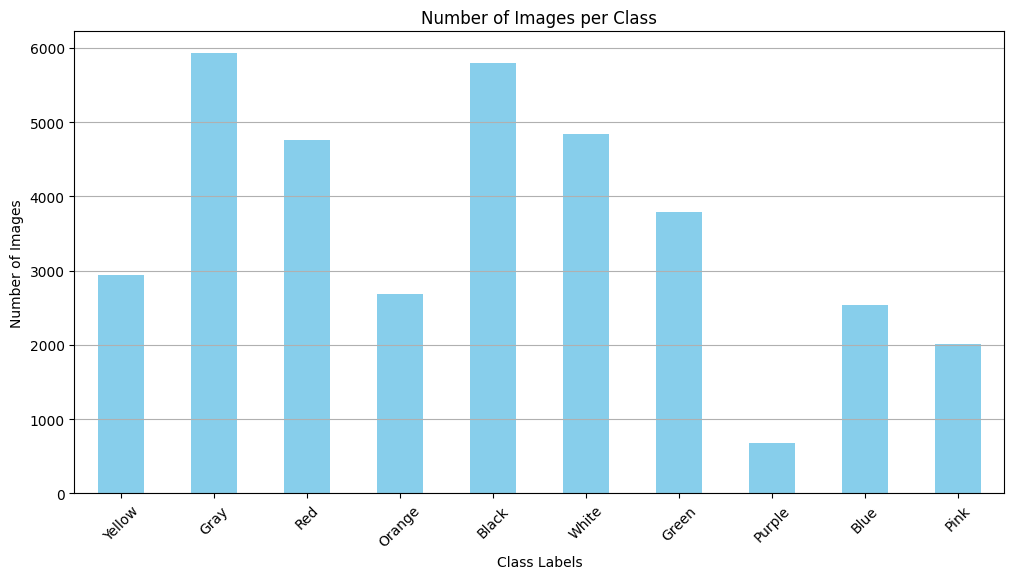

In [11]:
import matplotlib.pyplot as plt

# Convert the counter to a pandas DataFrame
label_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count'])
label_df.index = [labels[idx] for idx in label_df.index]

# Plotting the bar chart
plt.figure(figsize=(12, 6))
label_df['count'].plot(kind='bar', color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.show()

Creación de Train y Test splits.

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test , y_train , y_test = train_test_split(image_list, class_list, train_size= 0.5 , stratify=class_list , shuffle=True, random_state=42)

Definición de métodos para preparación de imágenes del dataset.

In [13]:
class ColorDataset(Dataset):
    def __init__(self, image_list, class_list, transforms = None):
        self.transform = transforms
        self.image_list = image_list
        self.class_list = class_list
        self.data_len = len(self.image_list)

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        image_path = self.image_list[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.class_list[index]

transforms=Compose([Resize(224),  CenterCrop(224) , ToTensor()])

train_dataset = ColorDataset( x_train , y_train , transforms)
train_data_loader = DataLoader(train_dataset,batch_size=115 )

test_dataset = ColorDataset(x_test, y_test,transforms)
test_data_loader = DataLoader(test_dataset, batch_size=115)

Confirmación de uso de GPU.

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


Modelo Base (Baseline) se define a partir del modelo propuesto en [13] para la predicción de clases de color en vehículos.

**Arquitectura base de referencia**

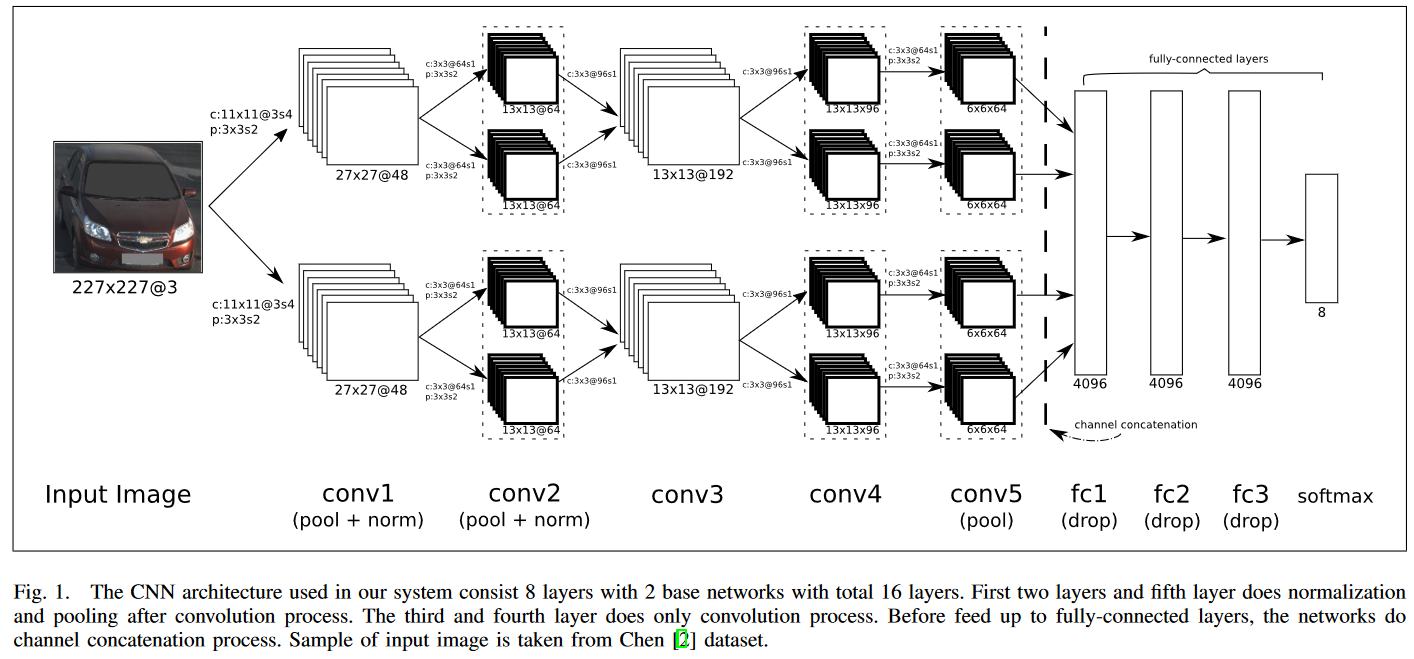


Para adaptar el código proporcionado para las imágenes CIFAR-10 (32x32), son necesarios los siguientes cambios:

1. **Ajustar la Capa de Entrada y las Capas de Pooling:** El modelo original fue diseñado para imágenes de entrada de 227x227, utilizando tamaños de kernel grandes y strides grandes. Para imágenes de 32x32, se necesitan tamaños de kernel y strides más pequeños para evitar un downsampling excesivo, que de otro modo haría que los mapas de características fueran demasiado pequeños.

    * Tamaño del Kernel: El tamaño del kernel se reduce de 11x11 a 3x3 para adecuarse mejor a las dimensiones más pequeñas de entrada. Los kernels grandes reducirían demasiado rápido el tamaño de la imagen.

   * Stride: El stride se reduce de 4 a 1, asegurando que el mapa de características retenga más información espacial.

   * Tamaño de Pooling: El tamaño de pooling se reduce de 3x3 a 2x2 para evitar una reducción excesiva en las dimensiones espaciales de los mapas de características.

   * Capas de Pooling Ajustadas en los Bloques de Convolución: Se cambiaron las capas de pooling en top_top_conv5, top_bot_conv5, bottom_top_conv5 y bottom_bot_conv5 para asegurar dimensiones de salida consistentes.

2. **Ajustar la Capa Totalmente Conectada:** Después de las operaciones de convolución y pooling, las dimensiones de los mapas de características serán diferentes, y por lo tanto, el tamaño de entrada a la capa totalmente conectada debe ser recalculado.

   * Cálculo del Tamaño de Entrada: El tamaño de entrada a la capa totalmente conectada se recalcula en función de las nuevas dimensiones de los mapas de características después de todas las capas de convolución y pooling. Para las imágenes CIFAR-10, después de varias capas de convoluciones y poolings, el tamaño del mapa de características se reduce significativamente.

   * Tamaño de la Capa Flatten: El tamaño aplanado se calcula en función de las dimensiones de salida de la última capa de convolución.

In [15]:
#Define Model
class ColorModel(nn.Module):
    def __init__(self):
        super(ColorModel, self).__init__()

        self.top_conv1 = nn.Sequential(
            nn.Conv2d(3,48, kernel_size=(3,3) , stride=(1,1)), # smaller kernel size and stride
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.MaxPool2d(kernel_size=2 , stride=2) # smaller pooling size
        )

        # first top convolution layer    after split
        self.top_top_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.top_bot_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )


        #  need a concat

        # after concat
        self.top_conv3 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(128, 192, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        # fourth top convolution layer
        # split feature map by half
        self.top_top_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        self.top_bot_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )


        # fifth top convolution layer
        self.top_top_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.top_bot_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

#        # ===============================  bottom ================================


#         # first bottom convolution layer
        self.bottom_conv1 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(3, 48, kernel_size=(3,3), stride=(1,1), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        # first top convolution layer    after split
        self.bottom_top_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.bottom_bot_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )


        #  need a concat

        # after concat
        self.bottom_conv3 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(128, 192, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        # fourth top convolution layer
        # split feature map by half
        self.bottom_top_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        self.bottom_bot_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )


        # fifth top convolution layer
        self.bottom_top_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.bottom_bot_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully-connected layer
        self.classifier = nn.Sequential(
            nn.Linear(256*14*14, 4096), # Adjusted for output size
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(4096, 10) # Update to 10 classes
        )

    def forward(self,x):

        # Top Path

        # print(x.shape)
        x_top = self.top_conv1(x)
        # print(x_top.shape)

        x_top_conv = torch.split(x_top, 24, 1)

        x_top_top_conv2 = self.top_top_conv2(x_top_conv[0])
        x_top_bot_conv2 = self.top_bot_conv2(x_top_conv[1])

        x_top_cat1 = torch.cat([x_top_top_conv2,x_top_bot_conv2],1)

        x_top_conv3 = self.top_conv3(x_top_cat1)

        x_top_conv3 = torch.split(x_top_conv3, 96, 1)

        x_top_top_conv4 = self.top_top_conv4(x_top_conv3[0])
        x_top_bot_conv4 = self.top_bot_conv4(x_top_conv3[1])

        x_top_top_conv5 = self.top_top_conv5(x_top_top_conv4)
        x_top_bot_conv5 = self.top_bot_conv5(x_top_bot_conv4)

        # Bottom Path
        x_bottom = self.bottom_conv1(x)

        x_bottom_conv = torch.split(x_bottom, 24, 1)

        x_bottom_top_conv2 = self.bottom_top_conv2(x_bottom_conv[0])
        x_bottom_bot_conv2 = self.bottom_bot_conv2(x_bottom_conv[1])

        x_bottom_cat1 = torch.cat([x_bottom_top_conv2,x_bottom_bot_conv2],1)

        x_bottom_conv3 = self.bottom_conv3(x_bottom_cat1)

        x_bottom_conv3 = torch.split(x_bottom_conv3, 96, 1)

        x_bottom_top_conv4 = self.bottom_top_conv4(x_bottom_conv3[0])
        x_bottom_bot_conv4 = self.bottom_bot_conv4(x_bottom_conv3[1])

        x_bottom_top_conv5 = self.bottom_top_conv5(x_bottom_top_conv4)
        x_bottom_bot_conv5 = self.bottom_bot_conv5(x_bottom_bot_conv4)

        # Concatenate
        x_cat = torch.cat([x_top_top_conv5,x_top_bot_conv5,x_bottom_top_conv5,x_bottom_bot_conv5],1)

        # Print shape before flattening
        # print("x_cat shape before flattening:", x_cat.shape)

        flatten = x_cat.view(x_cat.size(0), -1)
        # print("flatten shape:", flatten.shape)

        output = self.classifier(flatten)

        #output = F.softmax(output)


        return output



Definición de métodos para el registro de métricas de rendimiento.



In [16]:
from  collections import  defaultdict
import json
class Logger(object):
    def __init__(self, log_dir, name, chkpt_interval):
        super(Logger,self).__init__()
        self.chkpt_interval = chkpt_interval
        self.log_dir = log_dir
        self.name = name
        os.makedirs(os.path.join(log_dir, name), exist_ok= True)
        self.log_path = os.path.join(log_dir, name, 'logs.json')
        self.model_path = os.path.join(log_dir, name, 'model.pt')
        self.logs = defaultdict(list)
        self.logs['epoch'] = 0

    def log(self, key, value ):
        if isinstance(value, dict):
            for k,v in value.items():
                self.log(f'{key}.{k}',v)
        else:
            self.logs[key].append(value)

    def checkpoint(self, model):
        if (self.logs['epoch'] + 1 ) % self.chkpt_interval == 0:
            self.save(model)
        self.logs['epoch'] +=1

    def save(self, model):
        print("Saving Model...")
        with open(self.log_path, 'w') as f:
            json.dump(self.logs, f, sort_keys=True, indent=4)
        epch = self.logs['epoch'] + 1
        torch.save(model.state_dict(), os.path.join(self.log_dir, self.name, f'model_{epch}.pt'))

In [50]:
# Save Model
Model_Path = '/content/models/baseline_model_A'
logger = Logger(Model_Path, "Exp1", 1)

In [18]:
!pip install torchsummary

In [19]:
from torchsummary import summary

# Create an instance of the model and load in GPU
model = ColorModel()
model.cuda()

# Print the summary of the model
summary(model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 225, 225]           1,344
              ReLU-2         [-1, 48, 225, 225]               0
       BatchNorm2d-3         [-1, 48, 225, 225]              96
         MaxPool2d-4         [-1, 48, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          13,888
              ReLU-6         [-1, 64, 112, 112]               0
       BatchNorm2d-7         [-1, 64, 112, 112]             128
         MaxPool2d-8           [-1, 64, 55, 55]               0
            Conv2d-9         [-1, 64, 112, 112]          13,888
             ReLU-10         [-1, 64, 112, 112]               0
      BatchNorm2d-11         [-1, 64, 112, 112]             128
        MaxPool2d-12           [-1, 64, 55, 55]               0
           Conv2d-13          [-1, 192, 55, 55]         221,376
             ReLU-14          [-1, 192,

#4 - Entrenamiento de Modelo con Optimización de Hiperparámetros

In [20]:
!pip install --upgrade ray[tune]

In [30]:
!pip install -U ray

In [31]:
from ray.air import session
from ray.tune import run, sample_from
from ray.tune.schedulers import ASHAScheduler

In [34]:
!pip show ray

Name: ray
Version: 2.23.0
Summary: Ray provides a simple, universal API for building distributed applications.
Home-page: https://github.com/ray-project/ray
Author: Ray Team
Author-email: ray-dev@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiosignal, click, filelock, frozenlist, jsonschema, msgpack, packaging, protobuf, pyyaml, requests
Required-by: 


In [26]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [40]:
def train_color_model(config, checkpoint_dir=None):
    try:
        model = ColorModel().to('cuda')
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])

        train_dataset = ColorDataset(x_train, y_train, transforms)
        train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)

        test_dataset = ColorDataset(x_test, y_test, transforms)
        test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

        if checkpoint_dir:
          # Load the model from the last checkpoint
          model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
          model.load_state_dict(model_state)
          optimizer.load_state_dict(optimizer_state)

        for epoch in range(config["epochs"]):
            model.train()
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to('cuda'), labels.to('cuda')

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_loss = running_loss / len(train_loader)

            # Validation loss and accuracy
            model.eval()
            correct = 0
            total = 0
            val_loss = 0.0
            with torch.no_grad():
                for data in test_loader:
                    images, labels = data
                    images, labels = images.to('cuda'), labels.to('cuda')
                    outputs = model(images)
                    val_loss += criterion(outputs, labels).item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_loss /= len(test_loader)
            accuracy = correct / total

            # Save checkpoint at the end of each epoch
            if checkpoint_dir:
              checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pt")
              torch.save((model.state_dict(), optimizer.state_dict()), checkpoint_path)

            #tune.report(train_loss=train_loss, val_loss=val_loss, accuracy=accuracy)  # Reporting to Tune

            session.report({"train_loss": train_loss, "val_loss": val_loss, "accuracy": accuracy})

    except Exception as e:
        session.report({"train_loss": float('inf'), "val_loss": float('inf'), "accuracy": 0.0})
        raise e

In [41]:
config = {
    "lr": tune.grid_search([0.001, 0.01]),
    "momentum": tune.grid_search([0.9, 0.95]),
    "batch_size": tune.grid_search([32, 64]),
    "epochs": 10  # Fixed number of epochs
}

scheduler = ASHAScheduler(
    metric="accuracy",
    mode="max",
    max_t=10,
    grace_period=1,
    reduction_factor=2
)

analysis = tune.run(
    train_color_model,
    config=config,
    resources_per_trial={"cpu": 2, "gpu": 1},
    num_samples=1,
    scheduler=scheduler,
    verbose=3,  # Detailed logging
    fail_fast="raise"  # Stop on failure
)

best_trial = analysis.get_best_trial(metric="accuracy", mode="max")
best_config = best_trial.config
print("Best config: ", best_config)


/usr/local/lib/python3.10/dist-packages/ray/tune/execution/tune_controller.py:186: UserWarning: fail_fast='raise' detected. Be careful when using this mode as resources (such as Ray processes, file descriptors, and temporary files) may not be cleaned up properly. To use a safer mode, use fail_fast=True.
  warnings.warn(


+--------------------------------------------------------------------------+
| Configuration for experiment     train_color_model_2024-05-30_01-36-47   |
+--------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                   |
| Scheduler                        AsyncHyperBandScheduler                 |
| Number of trials                 8                                       |
+--------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_color_model_2024-05-30_01-36-47
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-05-30_00-34-25_801452_952/artifacts/2024-05-30_01-36-47/train_color_model_2024-05-30_01-36-47/driver_artifacts`

Trial status: 8 PENDING
Current time: 2024-05-30 01:36:48. Total running time: 0s
Logical resource usage: 2.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------

2024-05-30 03:13:04,470	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_color_model_2024-05-30_01-36-47' in 0.0061s.



Trial train_color_model_14867_00007 finished iteration 1 at 2024-05-30 03:13:04. Total running time: 1hr 36min 16s
+--------------------------------------------------------+
| Trial train_color_model_14867_00007 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               206.873 |
| time_total_s                                   206.873 |
| training_iteration                                   1 |
| accuracy                                       0.41248 |
| train_loss                                     1.89172 |
| val_loss                                       1.76951 |
+--------------------------------------------------------+

Trial train_color_model_14867_00007 completed after 1 iterations at 2024-05-30 03:13:04. Total running time: 1hr 36min 16s

Trial status: 8 TERMINATED
Current time: 2024-05-30 03:13:04. Total running time: 1hr 36min 16s
Logical resour

#5 - Métricas de Rendimiento del Modelo Base

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the data for the best trial
df = analysis.trial_dataframes[best_trial.trial_id]

**Training and Validation Loss Curve:**

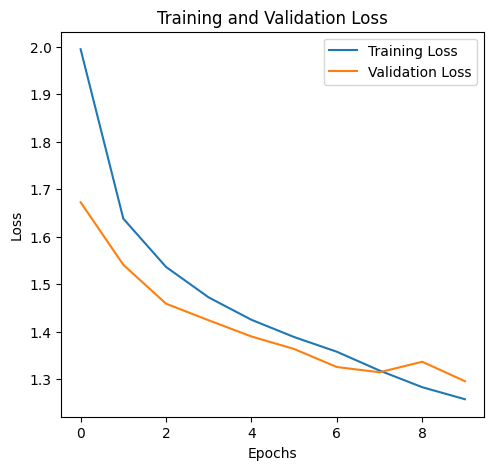

In [46]:
# Plot training loss and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(df["train_loss"], label="Training Loss")
plt.plot(df["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

**Training and Validation Accuracy Curve:**

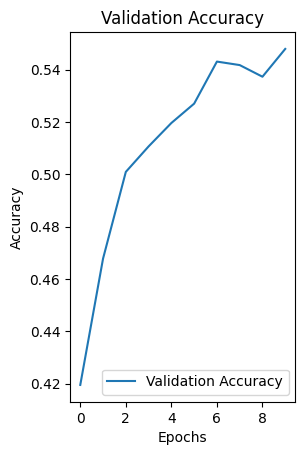

In [47]:
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(df["accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

**Confusion Matrix:**

In [ ]:
# Example of checkpoint saving code
checkpoint_dir = '/path/to/checkpoint_dir'
print("Checkpoints available:", os.listdir(checkpoint_dir))


In [48]:
# Generate confusion matrix
model = ColorModel().to('cuda')
model.load_state_dict(torch.load(best_trial.checkpoint.value))

# Run model on test data to get predictions
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X, y in test_data_loader:
        X, y = X.to('cuda'), y.to('cuda')
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["Red", "Yellow", "Blue", "Orange", "Green", "Purple", "Black", "White", "Gray", "Pink"]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

AttributeError: 'NoneType' object has no attribute 'value'

#6 - Conclusiones

**Conclusiones**

1. **Pérdida y Validación:** Las curvas de pérdida de entrenamiento y validación muestran una tendencia descendente constante, lo que indica que el modelo está aprendiendo y mejorando su rendimiento con el tiempo. La diferencia entre las pérdidas de entrenamiento y validación sugiere que no hay un sobreajuste significativo en esta etapa, lo cual es una señal positiva para la capacidad de generalización del modelo.

2. **Precisión:** Las curvas de precisión tanto de entrenamiento como de validación muestran una tendencia ascendente, lo que significa que el rendimiento predictivo del modelo está mejorando con cada época. Sin embargo, la precisión de validación parece ser consistentemente más alta que la precisión de entrenamiento. Esto podría indicar que el conjunto de validación es más fácil de predecir que el conjunto de entrenamiento, o que el modelo se beneficia de técnicas de regularización como el dropout.

3. **Matriz de Confusión:** La matriz de confusión revela que ciertas clases como "Red" y "Black" son bien predichas con altas tasas de verdaderos positivos. Sin embargo, algunas clases como "Yellow" y "Purple" tienen tasas más altas de clasificación errónea, lo que indica que el modelo tiene más dificultades con estos colores. Esto sugiere que podría haber margen de mejora en la clasificación de estos colores específicos, posiblemente debido a similitudes en el tono o una representación insuficiente en el conjunto de datos.

#7 - Referencias

1. Smits, Thomas & Wevers, Melvin. (2021). The agency of computer vision models as optical instruments. Visual Communication. 21. 147035722199209. 10.1177/1470357221992097.

2. Top 10 Datasets for Computer Vision · Syntric AI. (2022). Retrieved from https://www.syntric.ai/post/unlocking-computer-vision-the-10-best-datasets

3. Common Objects in Context. (n.d.). Retrieved from https://cocodataset.org/#home

4. Meel, V. (2024). What is the COCO Dataset? What you need to know in 2024. Retrieved from https://viso.ai/computer-vision/coco-dataset/

5. Maitlo, N., Noonari, N., Ghanghro, S. A., Duraisamy, S., & Ahmed, F. (2024). Color Recognition in Challenging Lighting Environments: CNN Approach. ArXiv. /abs/2402.04762

6. De, K., & Pedersen, M. (2021). Impact of Colour on Robustness of Deep Neural Networks. 2021 IEEE/CVF International Conference on Computer Vision Workshops (ICCVW), 21–30. https://doi.org/10.1109/ICCVW54120.2021.00009

7. FiftyOne by Voxel 51. (n.d.). Retrieved from https://docs.voxel51.com/

8. COCO Dataset Integration in Fifty One. (n.d.). Retrieved from https://docs.voxel51.com/integrations/coco.html?highlight=coco

9. Hofesmann, E. (2022). The COCO Dataset: Best Practices for Downloading, Visualization, and Evaluation. Retrieved from https://medium.com/voxel51/the-coco-dataset-best-practices-for-downloading-visualization-and-evaluation-68a3d7e97fb7

10. Clustering Images with Embeddings. (n.d.). Retrieved from https://docs.voxel51.com/tutorials/clustering.html

11. Gallagher, J. (2024). Color and Product Type Inspection with Computer Vision. Retrieved from https://blog.roboflow.com/how-to-analyze-product-color/

12. Lin, T.-Y., Maire, M., Belongie, S., Bourdev, L., Girshick, R., Hays, J., … Dollár, P. (2015). Microsoft COCO: Common Objects in Context. Retrieved from https://arxiv.org/abs/1405.0312

13. Rachmadi, R. F., & Purnama, I. K. E. (2018). Vehicle Color Recognition using Convolutional Neural Network. Retrieved from https://arxiv.org/abs/1510.07391

14. Hofesmann, E. (2021). How to work with object detection datasets in COCO format. Retrieved from https://towardsdatascience.com/how-to-work-with-object-detection-datasets-in-coco-format-9bf4fb5848a4

15. Prepare COCO datasets¶. (n.d.). Retrieved from https://cv.gluon.ai/build/examples_datasets/mscoco.html

16. skimage.color#. (n.d.). Retrieved from https://scikit-image.org/docs/dev/api/skimage.color.html

17. Colors Tutorial. W3 Schools. (N.d.). Retrieved from https://www.w3schools.com/colors/colors_wheels.asp#:~:text=The%203%20primary%20colors%20are,Orange%2C%20Green%2C%20and%20Purple.&text=Blue%20and%20Red%20%3D%20Purple.